In [2]:
import pandas as pd
import random
import numpy as np

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [3]:
random.seed(42)

In [4]:
PATH=r"D:\Dokumente\General_Data\other_people\Hard_Metalls\240422-new_data\worked_data\Paper\Data_Sets\\"

In [5]:
X_train_df=pd.read_csv(f"{PATH}X_train_240722.csv")
y_train=pd.read_csv(f"{PATH}y_train_240722.csv").Y

In [6]:
X_val_df = pd.read_csv(f"{PATH}X_val_240722.csv")
y_val = pd.read_csv(f"{PATH}y_val_240722.csv")

In [7]:
features_trost =  ['slope_0.2',  'norm_slope_0.2',  'curvature','curvature_linear', 'curvature_shift', 'norm_curvature','norm_curvature_linear', 'norm_curvature_shift', 'work_total','work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
features_others = ['Er(GPa)', 'H(GPa)']
all_features = features_trost.copy()
all_features.extend(features_others)

In [8]:
feature_sets = [features_trost, features_others, all_features]

In [9]:
random_forest = {
"name": "RFC",
"classifier": RandomForestClassifier(),
"param_distributions": {
"class_weight" : ["balanced"],
'max_depth': [3,  5,  7,  9, 11, 13, 15, 20, 30, 40],
'max_features': ['sqrt', "log2"],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [50, 100, 200, 300, 400, 500,600,]},
"smote": False}

In [10]:
xgb = {
"name": "XGB",
"classifier": XGBClassifier(objective='multi:softmax'),  # Specify multiclass classification with softmax loss
"param_distributions": {
'n_estimators': [50, 100, 200, 300],
'learning_rate': [0.01, 0.05, 0.1],
'max_depth': [3,  5,  7,  9, 11, 13, 15],  
'subsample': [0.8, 0.9, 1.0],  # Consider reducing overfitting for small datasets
  }, 
'smote': False
}

In [11]:
knn = {
"name": "KNN",
"classifier" : KNeighborsClassifier(),
"param_distributions": {
'n_neighbors': range(1,20),
'weights': ['uniform', 'distance'],
'algorithm' : ["auto"],
'leaf_size': [10, 15, 30, 45]},
"smote": False}

In [12]:
models = [random_forest, knn, xgb]

In [13]:
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'accuracy': make_scorer(accuracy_score)}

In [14]:
results = pd.DataFrame()

In [15]:
cv = StratifiedKFold(n_splits = 4)

In [16]:
scaler= StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_df[all_features])
X_val_scaled=scaler.transform(X_val_df[all_features])

In [17]:
X_train_scaled=pd.DataFrame(X_train_scaled, columns=all_features)
X_val_scaled =pd.DataFrame(X_train_scaled, columns=all_features)

In [18]:
for model in models:
    for features in feature_sets:
        estimator = model["classifier"]
        print(model["name"])
        print(features)
        if model["name"] == "KNN":
            X = X_train_scaled[features]
            y = y_train
            print(f"scaled features used")
        else:
            X = X_train_df[features]
            y = y_train
            
        param_distributions = model["param_distributions"]
        random_search = RandomizedSearchCV(estimator=estimator,
                                       param_distributions=param_distributions,
                                    scoring=scoring,
                                       n_jobs=-1,
                                       cv=cv, n_iter=50, refit='f1_macro')
        
        random_search.fit(X, y)
        current_data = pd.DataFrame(random_search.cv_results_)
        current_data["model"] = [model["name"]]*len(current_data)
        current_data["smote"] = [model["smote"]]*len(current_data)
        current_data["features"] = [features]*len(current_data)
        current_data["num_features"] = [len(features)]*len(current_data)
        results = pd.concat([results, current_data])
        results = results.reset_index(drop=True)

RFC
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
RFC
['Er(GPa)', 'H(GPa)']
RFC
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio', 'Er(GPa)', 'H(GPa)']
KNN
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
scaled features used
KNN
['Er(GPa)', 'H(GPa)']
scaled features used
KNN
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_

In [20]:
current_data.model.unique()

array(['XGB'], dtype=object)

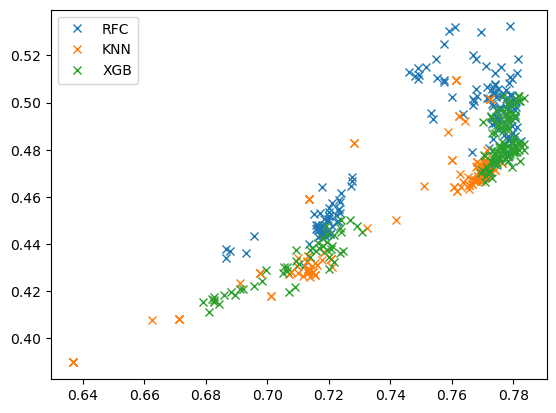

In [21]:
for model in results.model.unique():
    plot_data = results[results.model==model]
    plt.plot(plot_data.mean_test_f1_weighted, plot_data.mean_test_f1_macro, 'x', label=model)
    plt.legend()

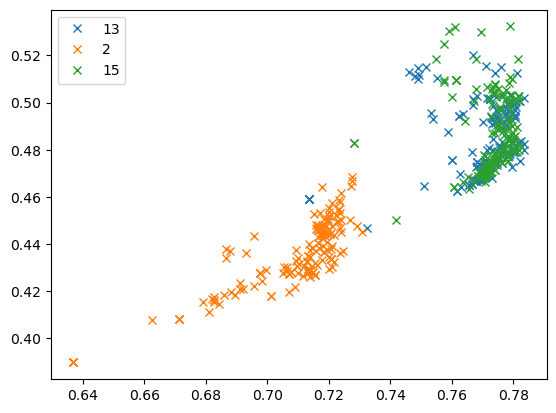

In [22]:
for model in results.num_features.unique():
    plot_data = results[results.num_features==model]
    plt.plot(plot_data.mean_test_f1_weighted, plot_data.mean_test_f1_macro, 'x', label=model)
    plt.legend()

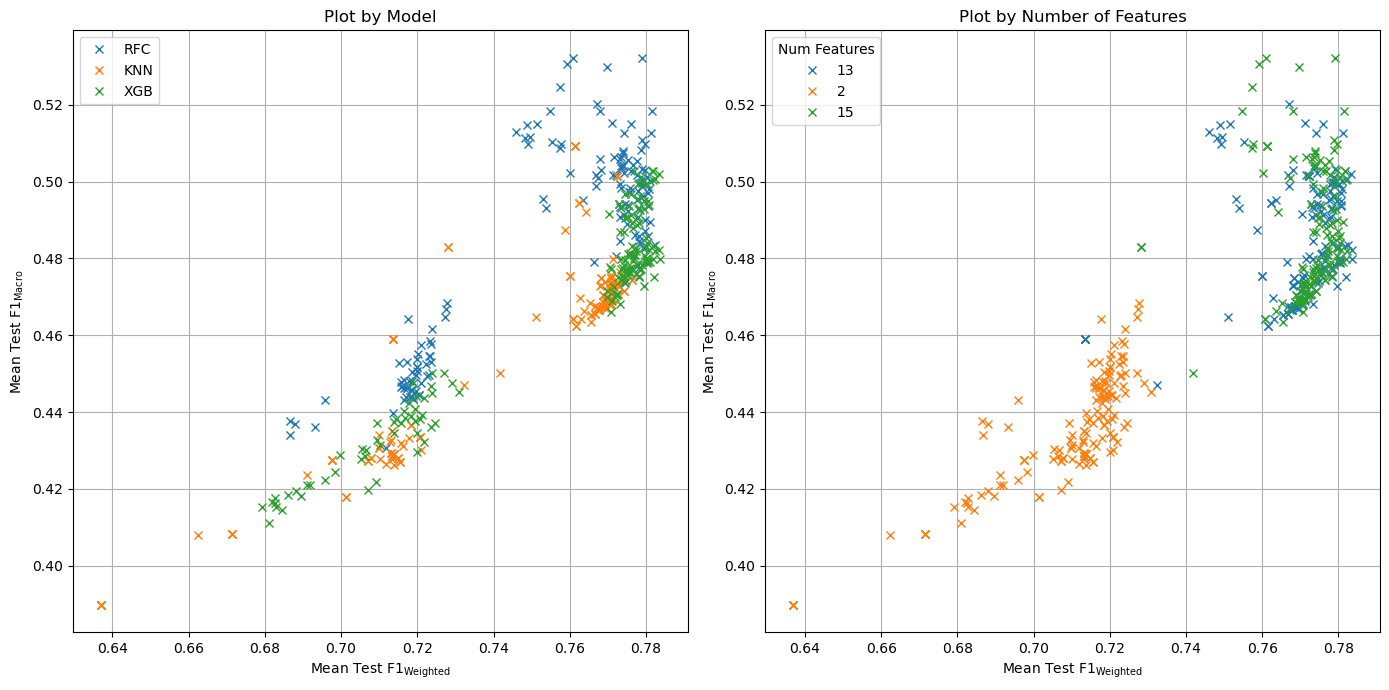

In [60]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot by model
for model in results['model'].unique():
    plot_data = results[results['model'] == model]
    ax1.plot(plot_data['mean_test_f1_weighted'], plot_data['mean_test_f1_macro'], 'x', label=model)
ax1.set_title('Plot by Model')
ax1.set_xlabel(r'Mean Test F1$_{\text{Weighted}}$')
ax1.set_ylabel(r'Mean Test F1$_{\text{Macro}}$')
ax1.legend()
ax1.grid(True)

# Plot by number of features
for num_features in results['num_features'].unique():
    plot_data = results[results['num_features'] == num_features]
    ax2.plot(plot_data['mean_test_f1_weighted'], plot_data['mean_test_f1_macro'], 'x', label=num_features)
ax2.set_title('Plot by Number of Features')
ax2.set_xlabel(r'Mean Test F1$_{\text{Weighted}}$')
ax2.set_ylabel(r'Mean Test F1$_{\text{Macro}}$')
ax2.legend(title='Num Features')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [62]:
results.to_pickle("random_search_used.pkl")

In [23]:
choosen_current_model = results[results.mean_test_f1_macro > results.mean_test_f1_macro.max()*0.99].sort_values(by = ["mean_test_f1_weighted"])

In [24]:
choosen_current_model[["mean_test_f1_macro", "mean_test_f1_weighted", "params", "features"]]

,mean_test_f1_macro,mean_test_f1_weighted,params,features
107,0.530514,0.759168,"{'n_estimators': 400, 'min_samples_split': 2, ...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
103,0.532149,0.760927,"{'n_estimators': 400, 'min_samples_split': 2, ...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
127,0.529857,0.769653,"{'n_estimators': 300, 'min_samples_split': 10,...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
135,0.532253,0.778972,"{'n_estimators': 100, 'min_samples_split': 10,...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."


In [25]:
results.iloc[125]

mean_fit_time                                                       6.192502
std_fit_time                                                        0.066012
mean_score_time                                                     0.157376
std_score_time                                                       0.01048
param_n_estimators                                                       600
param_min_samples_split                                                    2
param_min_samples_leaf                                                     4
param_max_features                                                      log2
param_max_depth                                                            3
param_class_weight                                                  balanced
params                     {'n_estimators': 600, 'min_samples_split': 2, ...
split0_test_f1_macro                                                0.512047
split1_test_f1_macro                                                0.542055

In [27]:
params = choosen_current_model.params.iloc[-1]

In [28]:
features = choosen_current_model.features.iloc[-1]

In [29]:
params

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 20,
 'class_weight': 'balanced'}

In [30]:
estimator = RandomForestClassifier( **params)

In [31]:
estimator = estimator.fit(X_train_df[features], y_train)

In [65]:
with open('random_forest_model_used.pkl', 'wb') as file:
    pickle.dump(estimator, file)

In [32]:
y_pred = estimator.predict(X_val_df[features])

In [33]:
f1_score(y_val.Y, y_pred, average='macro')

0.516453079084658

In [34]:
f1_score(y_val.Y, y_pred, average='weighted')

0.7831269808268604

In [35]:
X_val_3mN = X_val_df[X_val_df.mN==3]

In [36]:
y_val_3mN = y_val[X_val_df.mN==3]

In [37]:
y_val_3mN.mN.unique()

array([3], dtype=int64)

In [38]:
y_pred_3mN = estimator.predict(X_val_3mN[features])

In [39]:
f1_score(y_val_3mN.Y, y_pred_3mN, average='macro')

0.5457734342160572

In [40]:
f1_score(y_val_3mN.Y, y_pred_3mN, average='weighted')

0.8165732368989173

<Axes: >

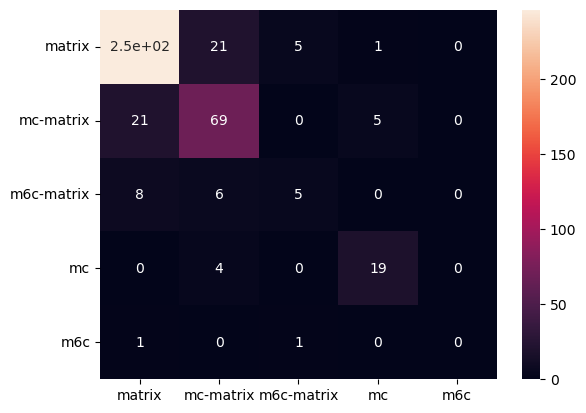

In [41]:
cm = confusion_matrix(y_val_3mN.Y, y_pred_3mN)
labels= {
    'matrix': 0,
    'mc-matrix': 1,
    'm6c-matrix': 2,
    'mc': 3,
    'm6c': 4,}
sns.heatmap(cm, annot=True,xticklabels=labels, yticklabels=labels)

<Axes: >

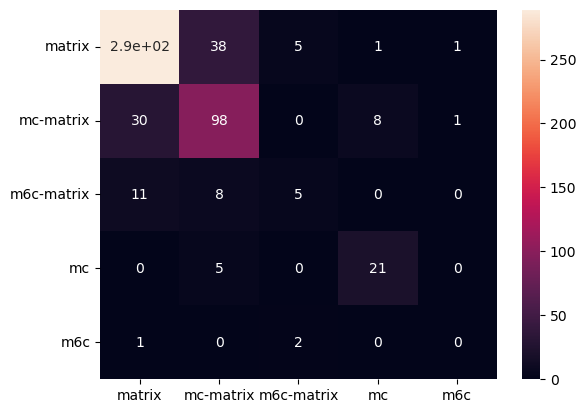

In [42]:
cm = confusion_matrix(y_val.Y, y_pred)
labels= {
    'matrix': 0,
    'mc-matrix': 1,
    'm6c-matrix': 2,
    'mc': 3,
    'm6c': 4,}
sns.heatmap(cm, annot=True,xticklabels=labels, yticklabels=labels)

In [43]:
import shap
#explainer = shap.TreeExplainer(best_estimator)
explainer=shap.explainers.Tree(estimator)
shap_values = explainer.shap_values(X_val_df[features])

# Visualize the SHAP values for the first test sample

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [70]:
with open('shap_explainer.pkl', 'wb') as file:
    pickle.dump(explainer, file)

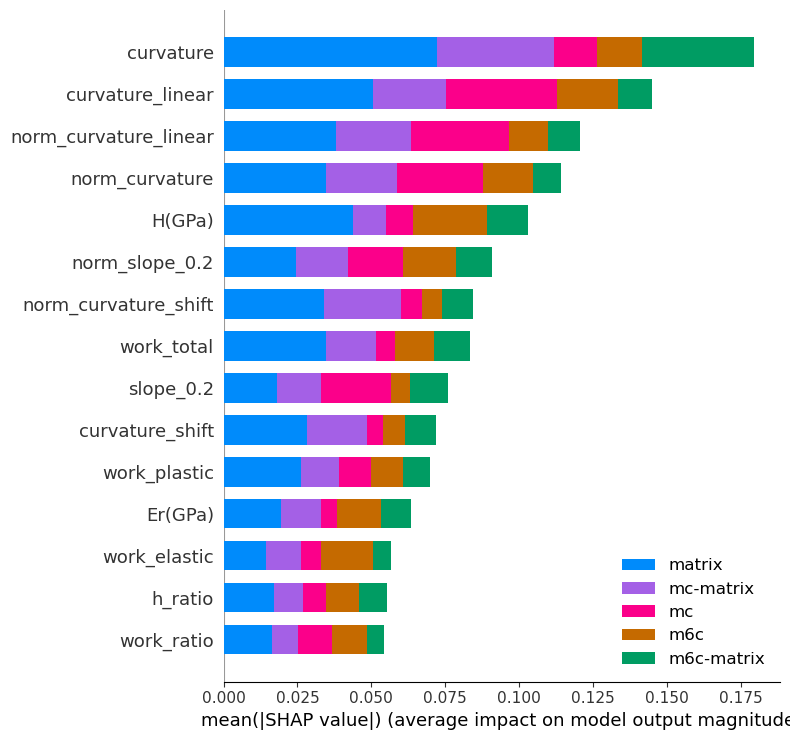

In [44]:
shap.summary_plot(shap_values, X_val_df[features], class_names=['matrix', 'mc-matrix', 'm6c-matrix', 'mc', 'm6c'])

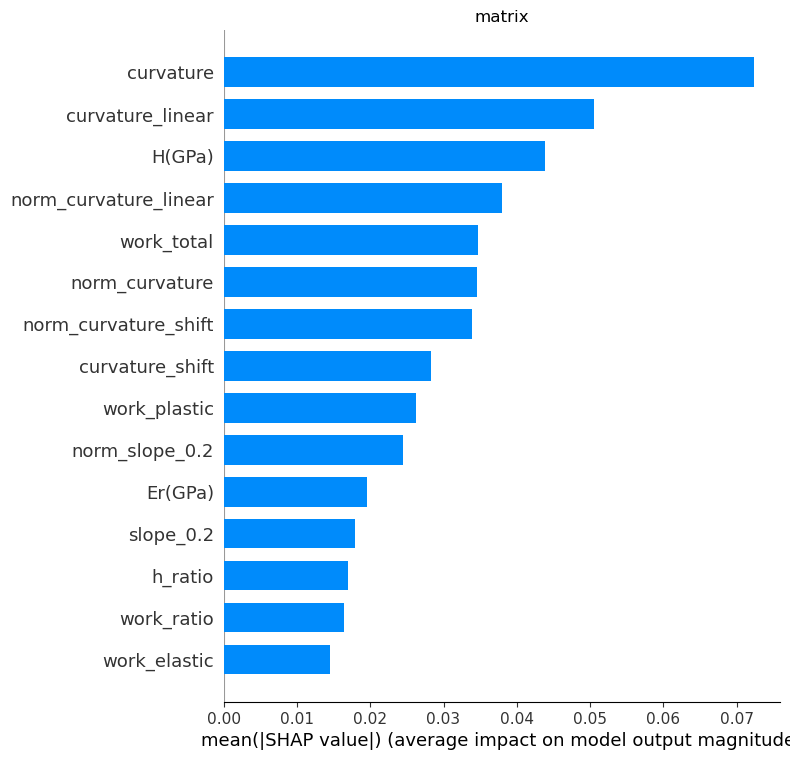

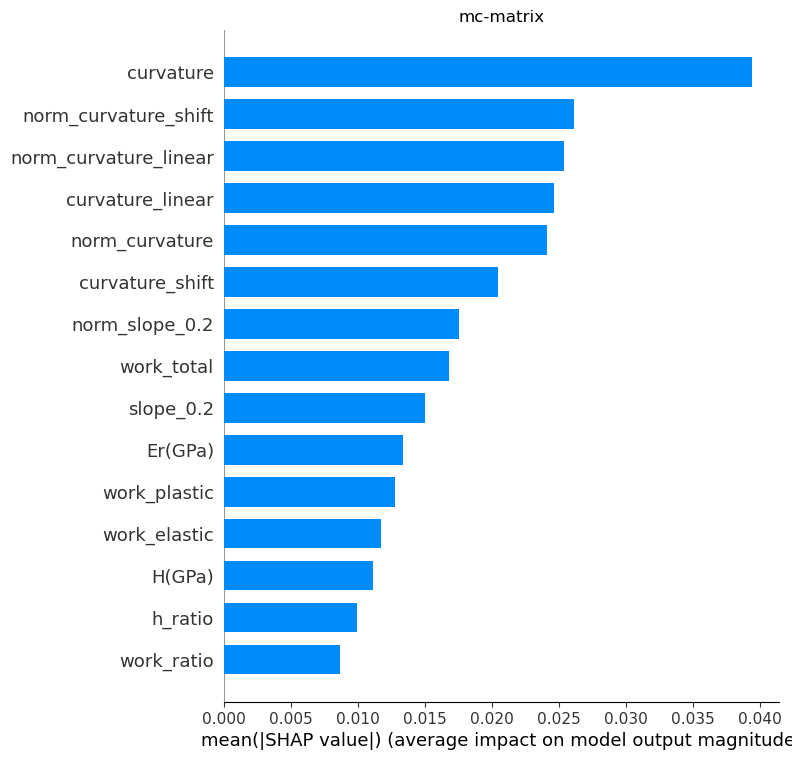

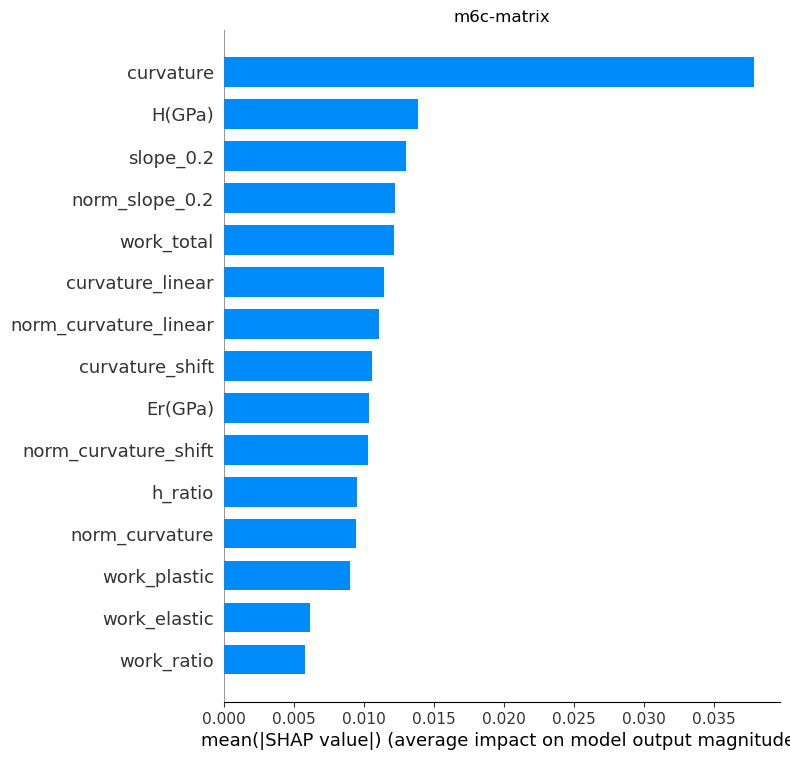

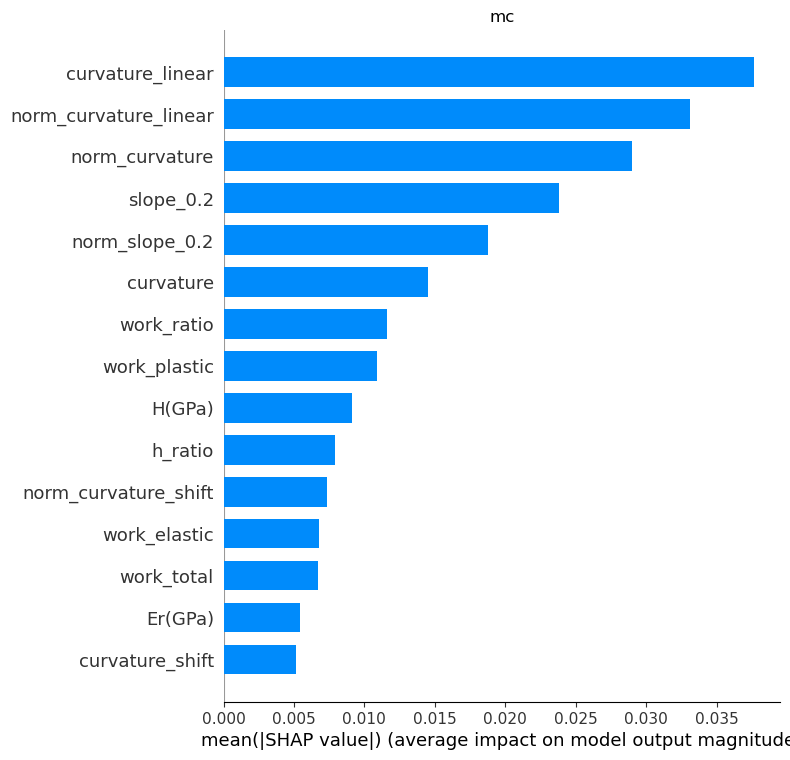

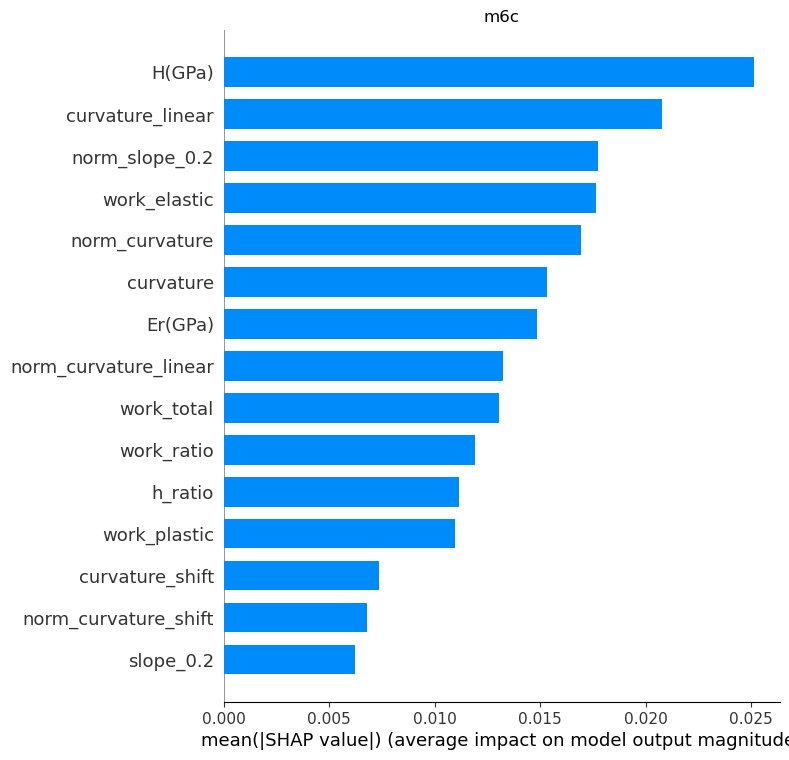

In [45]:
num_classes = len(shap_values)
for i in range(num_classes):
    plt.figure()
    class_names=['matrix', 'mc-matrix', 'm6c-matrix', 'mc', 'm6c']
    shap.summary_plot(shap_values[i], X_val_df[features], show=False,  plot_type="bar")
    plt.title(f'{class_names[i]}')
    plt.show()

In [46]:
X_val_df

,hc(nm),Pmax(µN),hmax(nm),Er(GPa),H(GPa),X(mm),Y(mm),slope_0.8,slope_0.8_score,slope_0.2,...,work_elastic,work_plastic,work_ratio,h_ratio,max_depth,map_name,file_names,Y_name,material,mN
0,78.871205,2993.073409,226.720232,194.960261,10.357724,45.31515,-26.79715,107360.831513,0.953060,99487.478567,...,44.503817,78.275621,0.637530,0.502873,98.538021,SV-map1-3mN,SV-7-map1-indents_0367.txt,matrix,SV,3
1,76.079520,2977.311555,302.299827,220.763856,10.848536,50.15305,-31.86345,123745.125098,0.938931,111718.129191,...,39.951524,82.092314,0.672646,0.396611,94.159206,LCV-map1-3mN,LCV-7-map1-indent_0105.txt,matrix,LCV,3
2,77.768417,2993.402716,315.975215,223.959984,10.570382,50.20055,-31.87525,109914.831164,0.824170,116659.210664,...,38.274917,80.750245,0.678430,0.469206,95.262055,LCV-map2-3mN,LCV-8-map2-indent_0290.txt,matrix,LCV,3
3,95.823509,2975.807853,231.484410,189.379185,7.726658,45.37525,-26.78025,125173.841764,0.947232,113295.501967,...,37.774644,80.858591,0.681585,0.388389,113.677957,SV-map2-3mN,SV-8-map2-indents_0112.txt,mc-matrix,SV,3
4,90.525509,2993.411262,254.168835,168.808255,8.336643,54.48395,-30.56185,119418.954768,0.958585,101003.574141,...,41.519142,76.822341,0.649158,0.341207,110.401789,SAV-map2-3mN,SA-8-map2-indents_0212.txt,mc-matrix,SAV,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,106.520354,4962.664430,507.299030,230.063957,10.581893,51.63625,-28.78375,164504.284104,0.951518,153605.374645,...,81.447746,177.473084,0.685434,0.375614,128.602040,BV-map1-5mN,s3-b-curves_0130.txt,matrix,BV,5
520,74.186683,2991.758196,231.484410,195.674203,11.298024,45.37005,-26.78805,104482.414871,0.955539,98548.446710,...,44.757827,74.875430,0.625875,0.445072,94.750498,SV-map2-3mN,SV-8-map2-indents_0236.txt,matrix,SV,3
521,72.778747,2991.847081,231.484410,202.684254,11.607878,45.38825,-26.78935,96965.673567,0.823178,98108.062220,...,48.686881,70.032713,0.589900,0.628653,92.931649,SV-map2-3mN,SV-8-map2-indents_0257.txt,matrix,SV,3
522,67.733635,2993.220651,324.857606,242.087925,12.535057,54.42365,-30.57225,118923.873888,0.810686,121601.650555,...,39.426525,67.765539,0.632188,0.523109,85.599833,SAV-map1-3mN,SA-7-map1-indent_0374.txt,mc-matrix,SAV,3


3
0.5457734342160572
0.8165732368989173


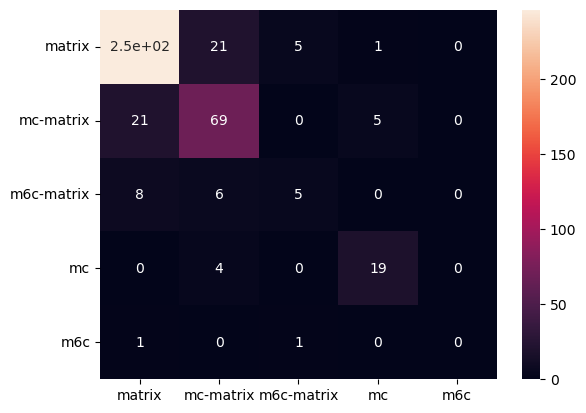

10
0.2329192546583851
0.5498588368153586


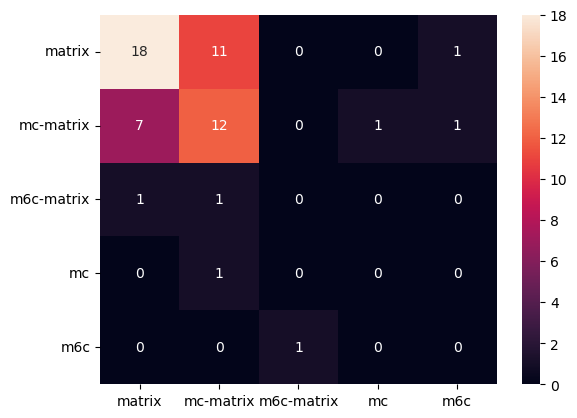

5
0.5638888888888889
0.7549707602339182


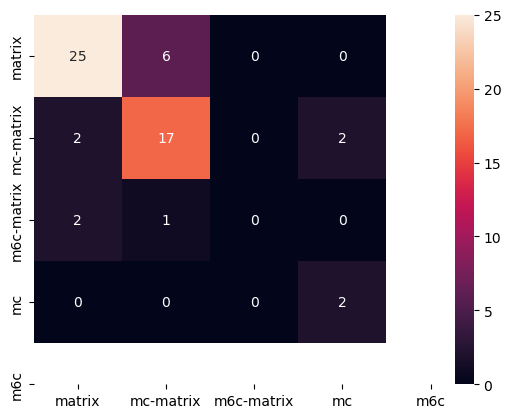

In [47]:
for force in X_val_df.mN.unique():
    print(force)
    print(f1_score(y_val.Y[X_val_df.mN==force], y_pred[X_val_df.mN==force], average='macro'))
    print(f1_score(y_val.Y[X_val_df.mN==force], y_pred[X_val_df.mN==force], average='weighted'))
    cm = confusion_matrix(y_val.Y[X_val_df.mN==force], y_pred[X_val_df.mN==force])
    labels= {
        'matrix': 0,
        'mc-matrix': 1,
        'm6c-matrix': 2,
        'mc': 3,
        'm6c': 4,}
    sns.heatmap(cm, annot=True,xticklabels=labels, yticklabels=labels)
    plt.show()

In [48]:
PATH_1=r"D:\Dokumente\General_Data\other_people\Hard_Metalls\240417_HSS_Wurfel\worked_data\DataSets\\"
wurfel = pd.read_csv(f"{PATH_1}data_wurfel.csv")
wurfel=wurfel[wurfel.map_name=='HSS_BW_3mN_map01']

In [49]:
wurfel["y_pred"] =estimator.predict(wurfel[features])

In [50]:
wurfel["X [µm]"]=wurfel["X(mm)"]-wurfel["X(mm)"].min()
wurfel["X [µm]"]=wurfel["X [µm]"]*1000
wurfel["X [µm]"]=wurfel["X [µm]"].round(2)
wurfel["Y [µm]"]=wurfel["Y(mm)"]-wurfel["Y(mm)"].max()
wurfel["Y [µm]"]=wurfel["Y [µm]"] *1000
wurfel["Y [µm]"]=wurfel["Y [µm]"].round(2)

In [51]:
mapping= {
    'matrix': 0,
    'mc-matrix': 1,
    'm6c-matrix': 2,
    'mc': 3,
    'm6c': 4,
    'mc-mc': 3,
    'm6c-m6c': 4,
    'mc-m6c': 5}

In [52]:
wurfel["y_encoded"] = wurfel.Y_name.apply(lambda x: mapping[x])

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


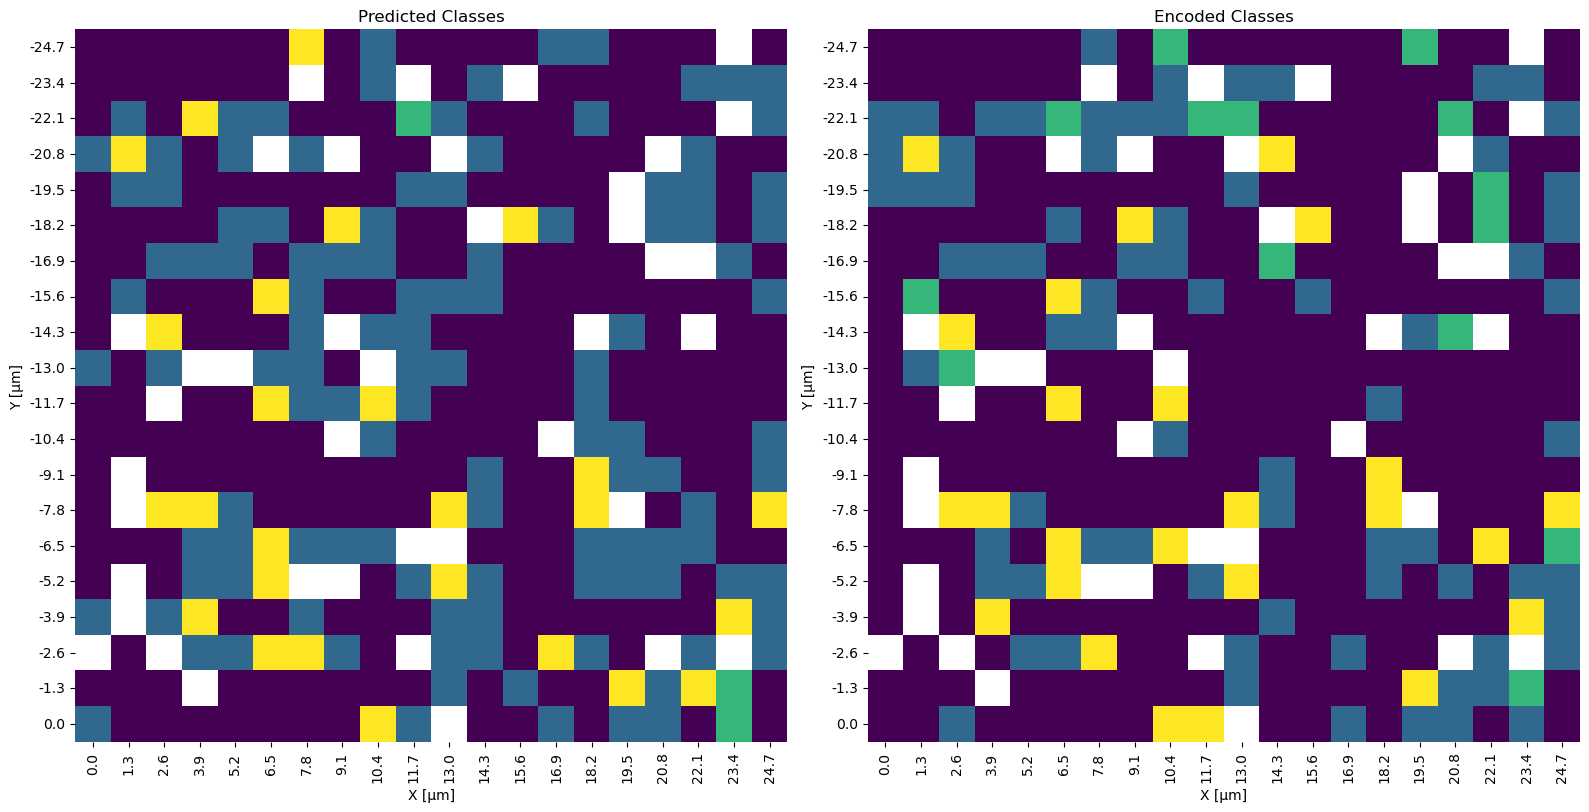

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


class_names = list(labels.keys())
class_values = list(labels.values())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # Create 1 row, 2 columns subplot

# Heatmap for predicted classes
df_pivoted_pred = wurfel.pivot(columns='X [µm]', index='Y [µm]', values='y_pred')
sns.heatmap(data=df_pivoted_pred, cmap=plt.cm.get_cmap('viridis'), cbar=False,
            cbar_kws={'ticks': class_values, 'label': 'Predicted Class'},
            square=True, ax=ax1, fmt='')

ax1.set_title('Predicted Classes')


# Remove x and y axis tick labels
#ax1.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Heatmap for encoded classes (assuming y_encoded exists)
df_pivoted_encoded = wurfel.pivot(columns='X [µm]', index='Y [µm]', values='y_encoded')
sns.heatmap(data=df_pivoted_encoded, cmap=plt.cm.get_cmap('viridis'), cbar=False,
            cbar_kws={'ticks': class_values},
            square=True, ax=ax2, fmt='')

ax2.set_title('Encoded Classes')
#ax2.collections[0].colorbar.set_ticklabels(labels)

# Remove x and y axis tick labels for encoded class heatmap
#ax2.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.show()


In [54]:
f1_score(wurfel.y_encoded, wurfel.y_pred, average="weighted")


0.7935192428035044

In [55]:
f1_score(wurfel.y_encoded, wurfel.y_pred, average="macro")

0.6377112015018773

<Axes: >

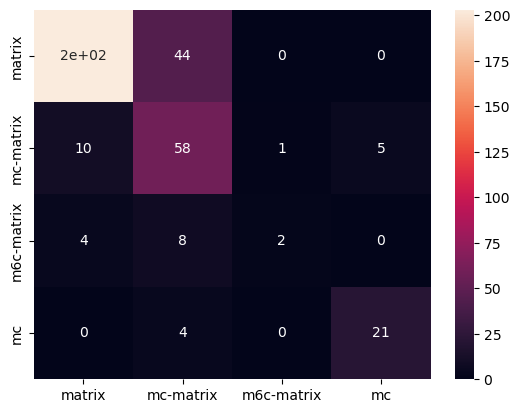

In [56]:
cm = confusion_matrix(wurfel.y_encoded, wurfel.y_pred)
labels= {
    'matrix': 0,
    'mc-matrix': 1,
    'm6c-matrix': 2,
    'mc': 3,}
sns.heatmap(cm, annot=True,xticklabels=labels, yticklabels=labels)

# Check if saving worked out

In [68]:
with open('random_forest_model_used.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Use the loaded model to make predictions
predictions_new = loaded_model.predict(X_val_3mN[features])

In [69]:
f1_score(y_val_3mN.Y, predictions_new, average='macro')

0.5457734342160572